#DETECTOR DE FRAUDES EN TRANSACCIONES CON TARJETAS DE CRÉDITO

DATASET: CreditCardData https://www.kaggle.com/datasets/anurag629/credit-card-fraud-transaction-data

OBJETIVO: Crear un modelo de machine learning que pueda clasificar de la mejor manera posible si una transacción es fraude o no lo es.

## LIBRERIAS

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree as treeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn import metrics
import scipy.stats as stats
from sklearn.metrics import confusion_matrix

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import cross_val_score, KFold



##Carga de Dataset Original

In [ ]:
df= pd.read_csv('/content/CreditCardData.csv')
df.head()

,Transaction ID,Date,Day of Week,Time,Type of Card,Entry Mode,Amount,Type of Transaction,Merchant Group,Country of Transaction,Shipping Address,Country of Residence,Gender,Age,Bank,Fraud
0,#3577 209,14-Oct-20,Wednesday,19,Visa,Tap,£5,POS,Entertainment,United Kingdom,United Kingdom,United Kingdom,M,25.2,RBS,0
1,#3039 221,14-Oct-20,Wednesday,17,MasterCard,PIN,£288,POS,Services,USA,USA,USA,F,49.6,Lloyds,0
2,#2694 780,14-Oct-20,Wednesday,14,Visa,Tap,£5,POS,Restaurant,India,India,India,F,42.2,Barclays,0
3,#2640 960,13-Oct-20,Tuesday,14,Visa,Tap,£28,POS,Entertainment,United Kingdom,India,United Kingdom,F,51.0,Barclays,0
4,#2771 031,13-Oct-20,Tuesday,23,Visa,CVC,£91,Online,Electronics,USA,USA,United Kingdom,M,38.0,Halifax,1


#LIMPIEZA DE DATOS

In [ ]:
#REVISAR VALORES NAN Y ELIMINARLOS

df.isna().sum()

#Optamos por eliminar los NAN ya que son muy pocos y no afectará si se eliminan.

df = df.dropna()
print(df.isna().sum())

Transaction ID            0
Date                      0
Day of Week               0
Time                      0
Type of Card              0
Entry Mode                0
Amount                    0
Type of Transaction       0
Merchant Group            0
Country of Transaction    0
Shipping Address          0
Country of Residence      0
Gender                    0
Age                       0
Bank                      0
Fraud                     0
dtype: int64


In [ ]:
#CONFIRMACIÓN DE VALORES NULL INEXISTENTES

print(df.isnull().sum())

Transaction ID            0
Date                      0
Day of Week               0
Time                      0
Type of Card              0
Entry Mode                0
Amount                    0
Type of Transaction       0
Merchant Group            0
Country of Transaction    0
Shipping Address          0
Country of Residence      0
Gender                    0
Age                       0
Bank                      0
Fraud                     0
dtype: int64


In [ ]:
#REVISAR TIPO DE DATOS
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99977 entries, 0 to 99999
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Transaction ID          99977 non-null  object 
 1   Date                    99977 non-null  object 
 2   Day of Week             99977 non-null  object 
 3   Time                    99977 non-null  int64  
 4   Type of Card            99977 non-null  object 
 5   Entry Mode              99977 non-null  object 
 6   Amount                  99977 non-null  object 
 7   Type of Transaction     99977 non-null  object 
 8   Merchant Group          99977 non-null  object 
 9   Country of Transaction  99977 non-null  object 
 10  Shipping Address        99977 non-null  object 
 11  Country of Residence    99977 non-null  object 
 12  Gender                  99977 non-null  object 
 13  Age                     99977 non-null  float64
 14  Bank                    99977 non-null

In [ ]:
#DATOS ÚNICOS EN CADA COLUMNA

# columnas a procesar
columnas = df.columns

# Itera a través de las columnas y obtén los valores únicos y sus conteos
for columna in columnas:
    valores_unicos = df[columna].unique()
    conteo_valores = df[columna].value_counts()

    print(f"Valores únicos en la columna '{columna}':")
    print(valores_unicos)

    print(f"Conteo de valores en la columna '{columna}':")
    print(conteo_valores)

    print("\n")

Valores únicos en la columna 'Transaction ID':
['#3577 209' '#3039 221' '#2694 780' ... '#3304 849' '#3532 129'
 '#3107 092']
Conteo de valores en la columna 'Transaction ID':
#2547 017    5
#2617 708    4
#2748 710    3
#3603 721    3
#3567 660    3
            ..
#2844 374    1
#2557 633    1
#3316 605    1
#2889 615    1
#3107 092    1
Name: Transaction ID, Length: 95657, dtype: int64


Valores únicos en la columna 'Date':
['14-Oct-20' '13-Oct-20' '16-Oct-20' '15-Oct-20']
Conteo de valores en la columna 'Date':
14-Oct-20    50173
13-Oct-20    49802
16-Oct-20        1
15-Oct-20        1
Name: Date, dtype: int64


Valores únicos en la columna 'Day of Week':
['Wednesday' 'Tuesday' 'Thursday' 'Friday']
Conteo de valores en la columna 'Day of Week':
Wednesday    50166
Tuesday      49785
Friday          14
Thursday        12
Name: Day of Week, dtype: int64


Valores únicos en la columna 'Time':
[19 17 14 23 20 18 11  1 21  0  8  9 15 22  7  3 12  4  5 10 13  2 16  6
 24]
Conteo de valores

In [ ]:
#ELIMINAR EL DATO ESCRITO INCORRECTAMENTE EN LA COLUMNA DE BANK

df['Bank'] = df['Bank'].str.replace('Barlcays', 'Barclays')

#Tenemos 2 terminos que se refieren al mismo banco pero está mal escrito  Barclays y Barlcays

In [ ]:
#ELIMINAR EL SIMBOLO DE LIBRA ESTERLINA

df['Amount'] = df['Amount'].str.replace('£', '')

In [ ]:
#ELIMINAR ENTRADAS QUE PUEDEN SER POCO SIGNIFICATIVAS SÓLO HAY 26 CELDAS DE LOS DÍAS JUEVES Y VIERNES.

print(df['Day of Week'].value_counts())

df_fraud = df[df['Fraud'] == True]
h = df_fraud.groupby('Day of Week')['Fraud'].count()
print(h)

Wednesday    50166
Tuesday      49785
Friday          14
Thursday        12
Name: Day of Week, dtype: int64
Day of Week
Friday          1
Thursday        2
Tuesday      3731
Wednesday    3458
Name: Fraud, dtype: int64


In [ ]:
#ELIMINAR ENTRADAS QUE PUEDEN SER POCO SIGNIFICATIVAS SÓLO HAY 3 CELDAS DE FRAUDE EN LOS DÍAS JUEVES Y VIERNES.
df = df[(df['Day of Week'] == 'Tuesday') | (df['Day of Week'] == 'Wednesday')]

In [ ]:
#SELECCIONAR LOS TIPOS DE DATOS CORRECTOS DE CADA COLUMNA

df = df.astype({'Shipping Address':'category',
        'Country of Residence': 'category',
        'Gender': 'category',
        'Bank':  'category',
        'Fraud': 'bool',
        'Country of Transaction' : 'category',
        'Merchant Group' : 'category',
        'Type of Transaction': 'category',
        'Amount' : 'int',
        'Entry Mode': 'category',
        'Type of Card': 'category',
        'Time': 'int',
        'Day of Week': 'category'
        })

df['Date'] = pd.to_datetime(df['Date'])

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99951 entries, 0 to 99999
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Transaction ID          99951 non-null  object        
 1   Date                    99951 non-null  datetime64[ns]
 2   Day of Week             99951 non-null  category      
 3   Time                    99951 non-null  int64         
 4   Type of Card            99951 non-null  category      
 5   Entry Mode              99951 non-null  category      
 6   Amount                  99951 non-null  int64         
 7   Type of Transaction     99951 non-null  category      
 8   Merchant Group          99951 non-null  category      
 9   Country of Transaction  99951 non-null  category      
 10  Shipping Address        99951 non-null  category      
 11  Country of Residence    99951 non-null  category      
 12  Gender                  99951 non-null  catego

In [ ]:
#DATASET DESBALANCEADO
print(df['Fraud'].value_counts())

#Tenemos más casos negativos (osea que no son fraude) que casos positivos.

False    92762
True      7189
Name: Fraud, dtype: int64


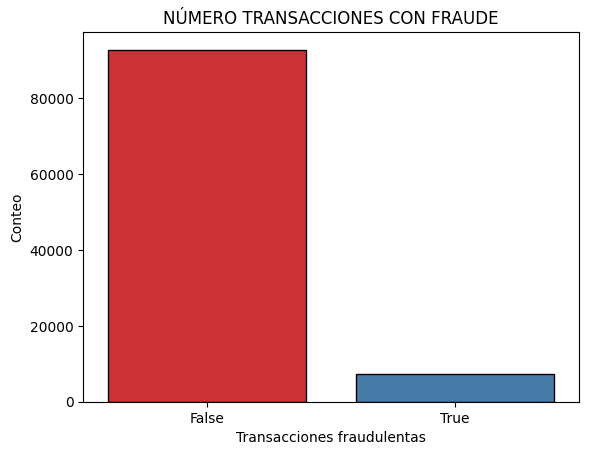

In [ ]:
ax = sns.countplot(x = df['Fraud'], palette = "Set1", edgecolor = "black")
ax.set_title('NÚMERO TRANSACCIONES CON FRAUDE')
ax.set(xlabel = 'Transacciones fraudulentas')
ax.set(ylabel='Conteo')
plt.show()

#EXPLORACIÓN DE DATOS

In [ ]:
#MEDIDAS DE TENDENCIA CENTRAL

df.describe()

,Time,Amount,Age
count,99951.000000,99951.000000,99951.000000
mean,14.563776,112.576212,44.994199
std,5.308407,123.438543,9.948101
min,0.000000,5.000000,15.000000
25%,10.000000,17.000000,38.200000
50%,15.000000,30.000000,44.900000
75%,19.000000,208.000000,51.700000
max,24.000000,400.000000,86.100000


In [ ]:
#DÍA DE MÁS TRANSACCIONES
df['Day of Week'].value_counts()

Wednesday    50166
Tuesday      49785
Name: Day of Week, dtype: int64

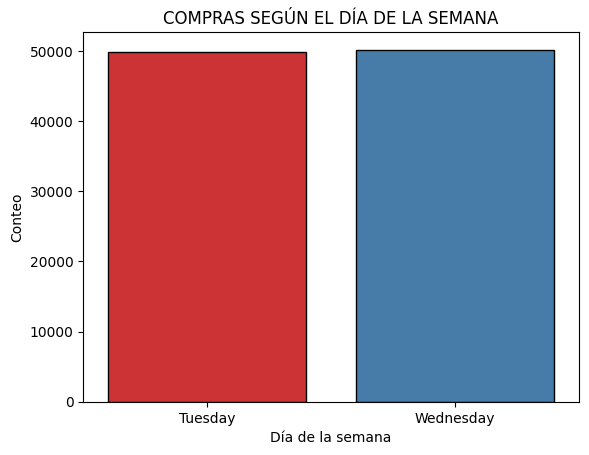

In [ ]:
#DÍA DE MÁS TRANSACCIONES

ax = sns.countplot(x = df['Day of Week'],palette = "Set1", edgecolor = "black")
ax.set_title('COMPRAS SEGÚN EL DÍA DE LA SEMANA')
ax.set(xlabel = 'Día de la semana')
ax.set(ylabel='Conteo')
plt.show()

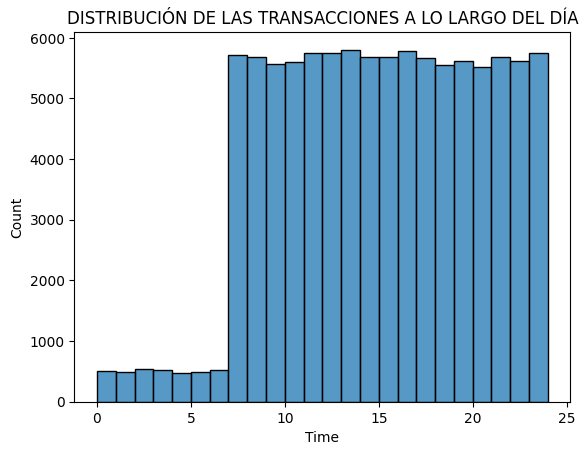

In [ ]:
#DISTRIBUCIÓN DE LAS TRANSACCIONES A LO LARGO DEL DÍA

ax = sns.histplot(df['Time'], bins=24, fill=True, shrink=1, kde=False)
ax.set_title('DISTRIBUCIÓN DE LAS TRANSACCIONES A LO LARGO DEL DÍA')
plt.show()

#Observamos que de las 0:00 hasta las 7am hay muy pocas transacciones

In [ ]:
#TARJETA MÁS UTILIZADA

df['Type of Card'].value_counts()

Visa          53784
MasterCard    46167
Name: Type of Card, dtype: int64

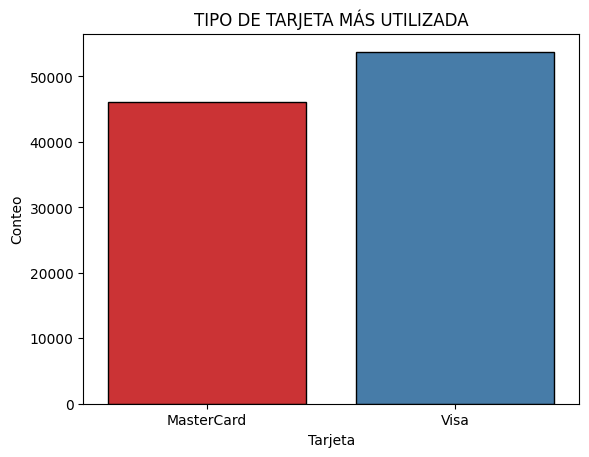

In [ ]:
#TARJETA MÁS UTILIZADA

ax = sns.countplot(x = df['Type of Card'],palette = "Set1", edgecolor = "black")
ax.set_title('TIPO DE TARJETA MÁS UTILIZADA')
ax.set(xlabel = 'Tarjeta')
ax.set(ylabel='Conteo')
plt.show()

In [ ]:
#MODO DE EJECUCIÓN DEL PAGO SEGÚN TIPO DE TARJETA

pd.crosstab(df['Entry Mode'],df['Type of Card'])

Type of Card,MasterCard,Visa
Entry Mode,,
CVC,15616,17848
PIN,22950,27001
Tap,7601,8935


In [ ]:
#MODO DE EJECUCIÓN DEL PAGO
df['Entry Mode'].value_counts()

PIN    49951
CVC    33464
Tap    16536
Name: Entry Mode, dtype: int64

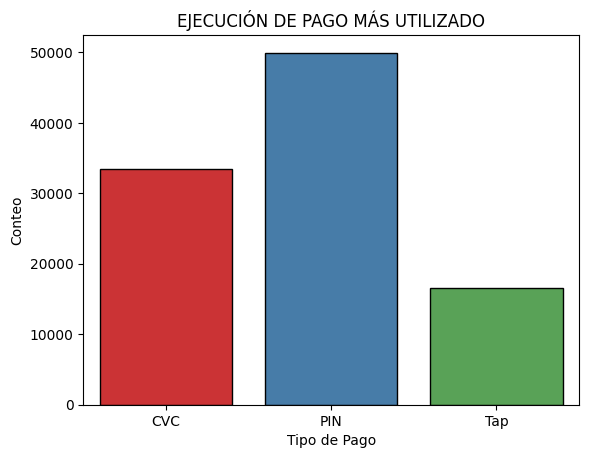

In [ ]:
#MODO DE EJECUCIÓN DEL PAGO

ax = sns.countplot(x = df['Entry Mode'],palette = "Set1", edgecolor = "black")
ax.set_title('EJECUCIÓN DE PAGO MÁS UTILIZADO')
ax.set(xlabel = 'Tipo de Pago')
ax.set(ylabel='Conteo')
plt.show()

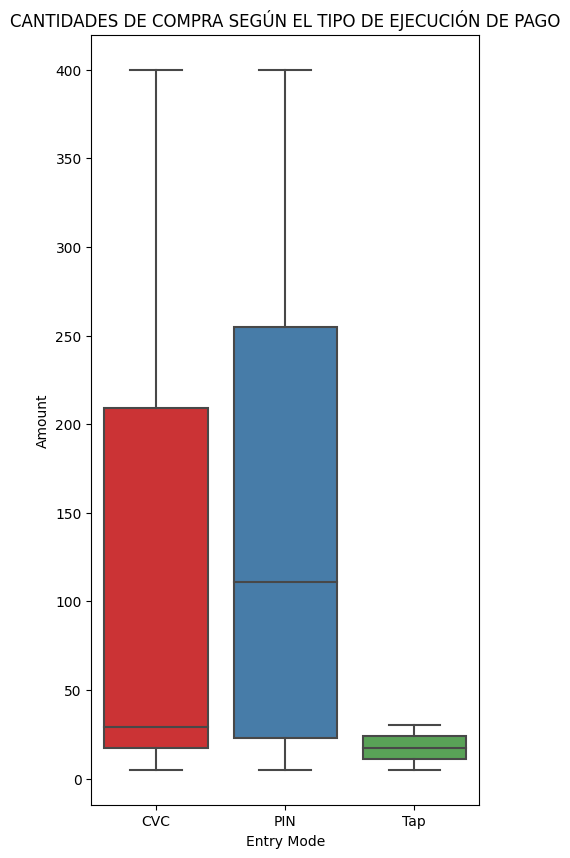

In [ ]:
#DIFERENCIAS DE DISTRIBUCIÓN ENTRE TIPOS DE PAGO

plt.figure(figsize=(5, 10))

ax = sns.boxplot(x = df['Entry Mode'], y= df['Amount'], palette = "Set1" )
ax.set_title('CANTIDADES DE COMPRA SEGÚN EL TIPO DE EJECUCIÓN DE PAGO')
plt.show()

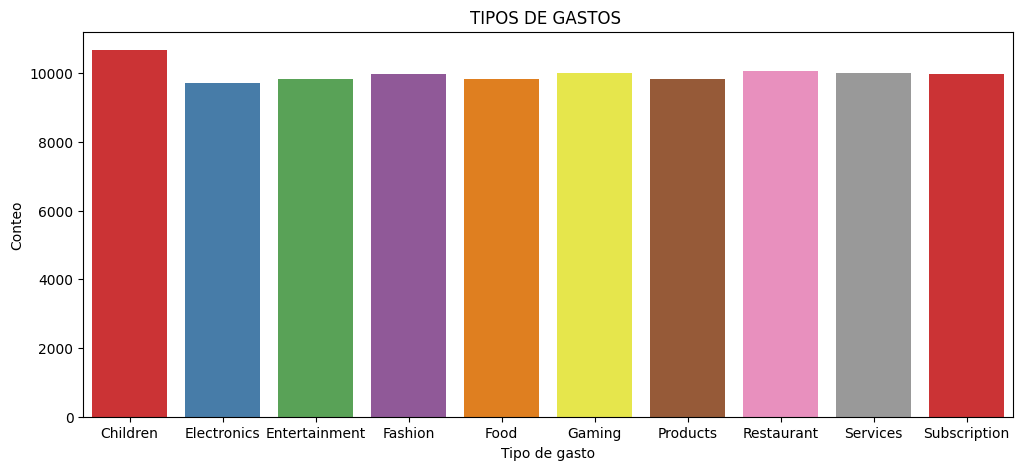

In [ ]:
#TIPO DE GASTO

plt.figure(figsize=(12, 5))

ax = sns.countplot(x = df['Merchant Group'],palette = "Set1" )
ax.set_title('TIPOS DE GASTOS ')
ax.set(xlabel = 'Tipo de gasto')
ax.set(ylabel='Conteo')
plt.show()

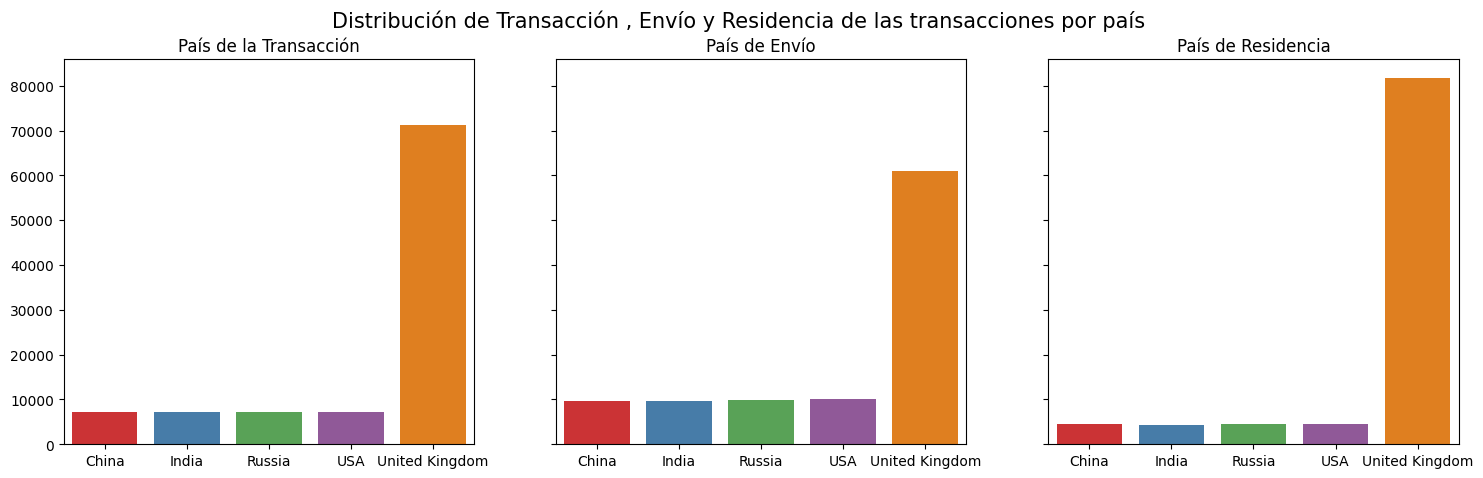

In [ ]:
#DISTRIBUCIÓN POR PAÍSES

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)

sns.countplot(x = df['Country of Transaction'],palette = "Set1", ax=axes[0])
sns.countplot(x = df['Shipping Address'],palette = "Set1",ax=axes[1])
sns.countplot(x = df['Country of Residence'],palette = "Set1", ax=axes[2])


axes[0].set(xlabel='', ylabel='', title='País de la Transacción')
axes[1].set(xlabel='', ylabel='', title='País de Envío')
axes[2].set(xlabel='', ylabel='', title='País de Residencia')


fig.suptitle('Distribución de Transacción , Envío y Residencia de las transacciones por país', fontsize=15);

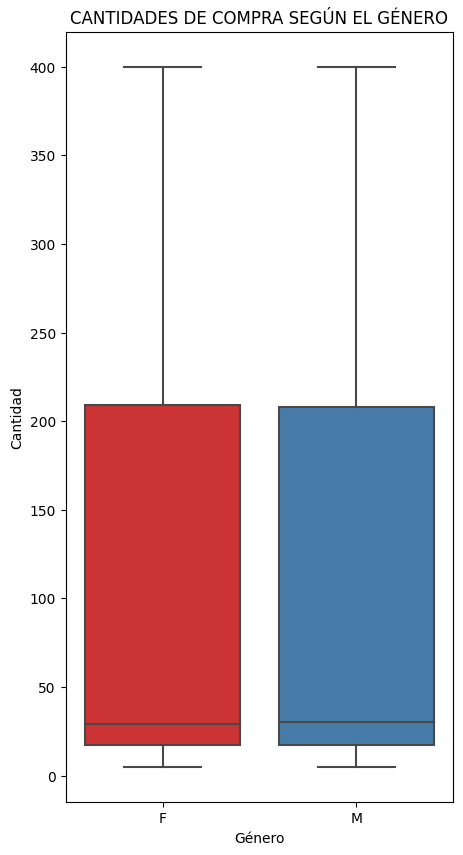

In [ ]:
#DIFERENCIAS DE DISTRIBUCIÓN DE CATIDAD DE COMPRA ENTRE GÉNERO

plt.figure(figsize=(5, 10))

ax = sns.boxplot(x = df['Gender'], y= df['Amount'],palette = "Set1" )
ax.set_title('CANTIDADES DE COMPRA SEGÚN EL GÉNERO')
ax.set(xlabel = 'Género')
ax.set(ylabel='Cantidad')
plt.show()

In [ ]:
#FILTRO POR GÉNEROS

df_gender_F = df[df['Gender'] == 'F'].reset_index()
df_gender_M = df[df['Gender'] == 'M'].reset_index()

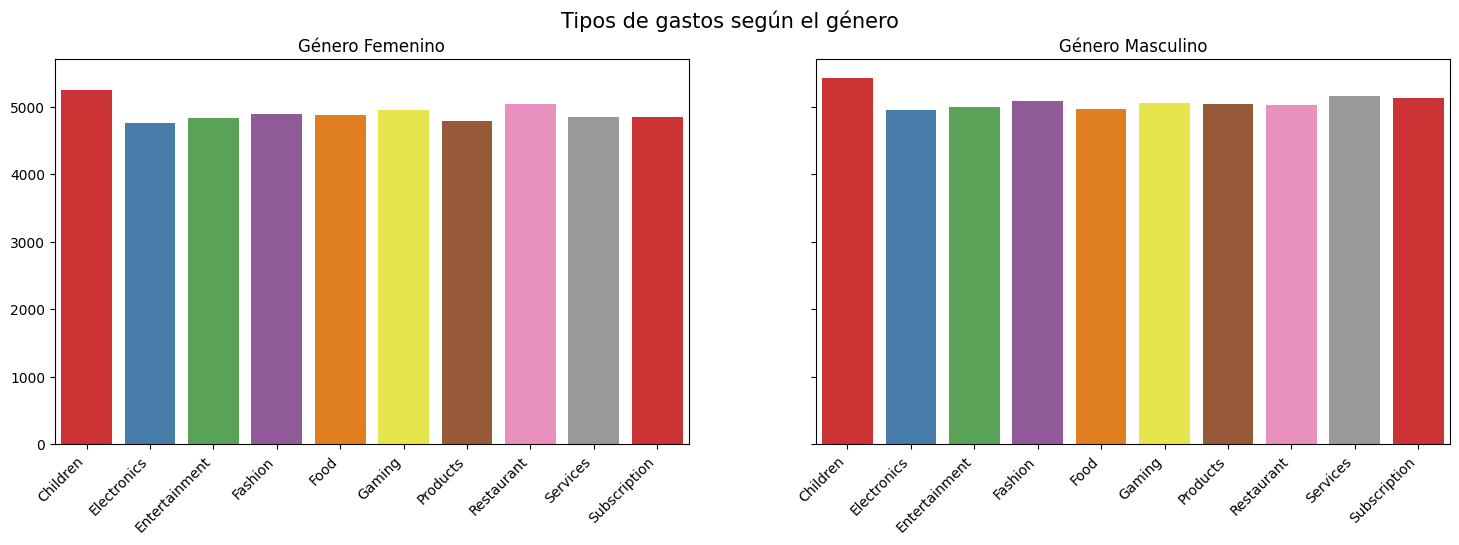

In [ ]:
#TIPO DE GASTOS SEGÚN EL GÉNERO FEMENINO Y MASCULINO

fig, axes = plt.subplots(1, 2, figsize=(18, 5), sharex=True, sharey=True)

sns.countplot(x = df_gender_F['Merchant Group'],palette = "Set1", ax=axes[0])
sns.countplot(x = df_gender_M['Merchant Group'],palette = "Set1",ax=axes[1])



axes[0].set(xlabel='', ylabel='', title='Género Femenino')
axes[1].set(xlabel='', ylabel='', title='Género Masculino')

axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')


fig.suptitle('Tipos de gastos según el género', fontsize=15);

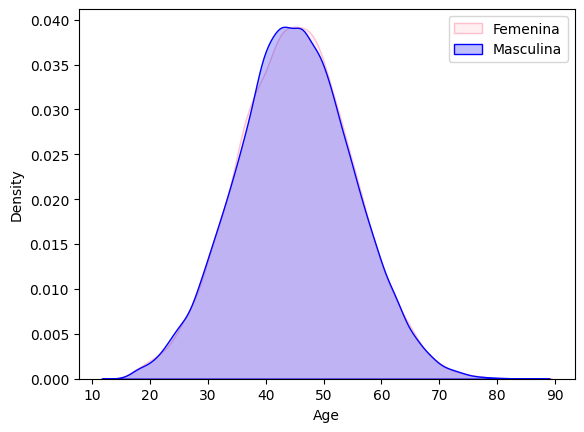

In [ ]:
#DENSIDAD DE EDADES SEGÚN EL GÉNERO

edad_femenina = df_gender_F['Age']
edad_masculina = df_gender_M['Age']

sns.kdeplot(edad_femenina,color='pink', label='Femenina',fill=True)
sns.kdeplot(edad_masculina, color='blue', label='Masculina',fill=True)

plt.legend()
plt.show()

In [ ]:
#BANCOS Y FRAUDES DETECTADOS

df_fraud = df[df['Fraud'] == True]
fraudes_bancarios = df_fraud.groupby('Bank')['Fraud'].count().reset_index()
fraudes_bancarios

,Bank,Fraud
0,Barclays,2981
1,HSBC,653
2,Halifax,678
3,Lloyds,693
4,Metro,804
5,Monzo,728
6,RBS,652


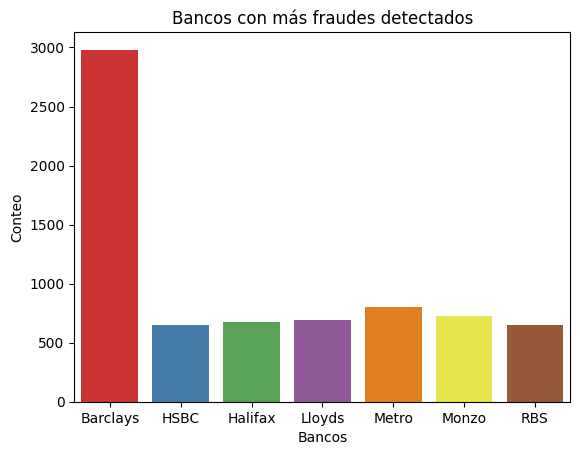

In [ ]:
#BANCOS Y FRAUDES DETECTADOS

ax = sns.barplot(x = fraudes_bancarios['Bank'], y = fraudes_bancarios['Fraud'],palette = "Set1")
ax.set_title('Bancos con más fraudes detectados')
ax.set(xlabel = 'Bancos')
ax.set(ylabel='Conteo')
plt.show()

In [ ]:
#HORARIO CON MÁS FRAUDES
fraudes_bancarios = df_fraud.groupby('Time')['Fraud'].count().reset_index()
fraudes_bancarios

,Time,Fraud
0,0,509
1,1,483
2,2,536
3,3,531
4,4,474
5,5,488
6,6,515
7,7,209
8,8,194
9,9,203


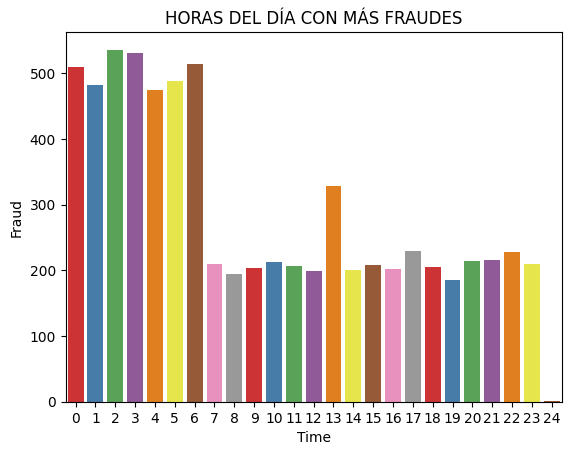

In [ ]:
#HORAS DEL DÍA CON MÁS FRAUDES

ax = sns.barplot(x = fraudes_bancarios['Time'], y = fraudes_bancarios['Fraud'],palette = "Set1" )
ax.set_title('HORAS DEL DÍA CON MÁS FRAUDES')
plt.show()

<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


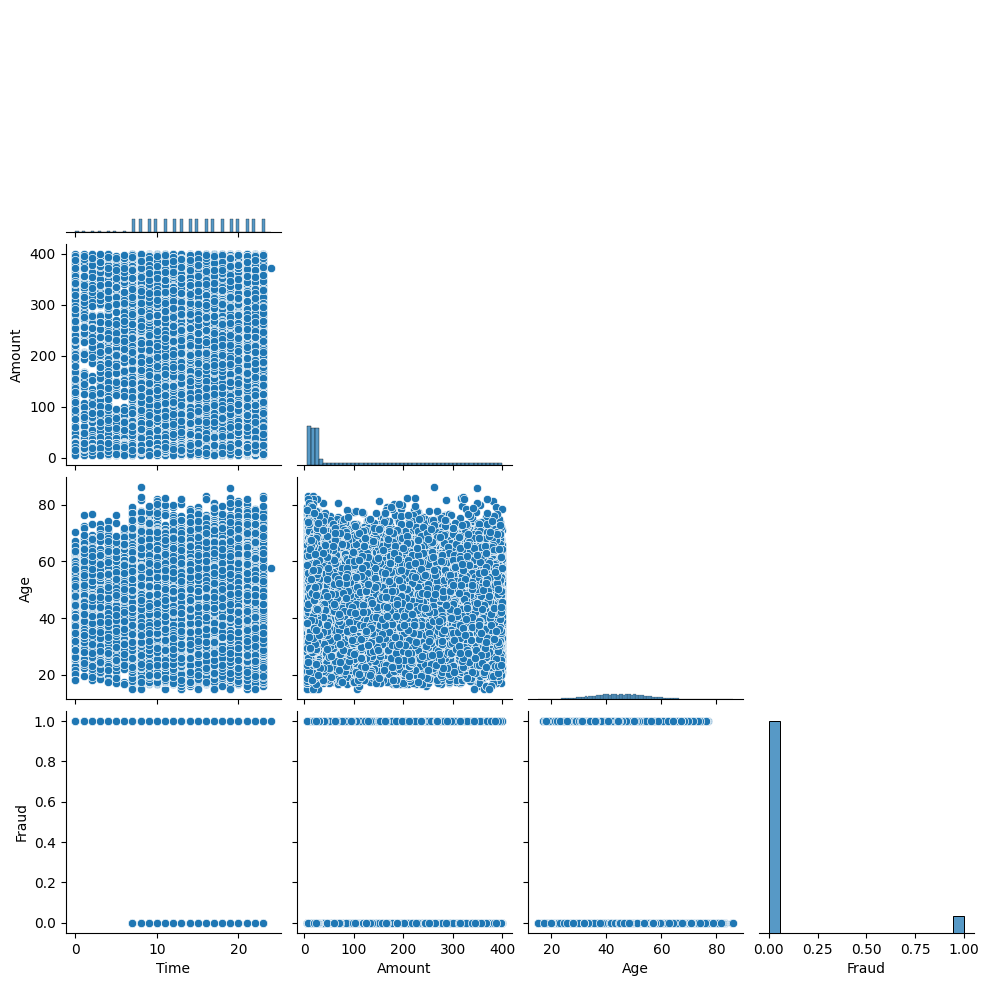

In [ ]:
#PAIRPLOT
sns.pairplot(df,corner=True)

In [ ]:
#CORRELACÍÓN ENTRE VARIABLES

df.corr()

<ipython-input-35-bd929f9ecd56>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,Time,Amount,Age,Fraud
Time,1.000000,0.030071,-0.000975,-0.286317
Amount,0.030071,1.000000,-0.004247,-0.109896
Age,-0.000975,-0.004247,1.000000,-0.002810
Fraud,-0.286317,-0.109896,-0.002810,1.000000


<ipython-input-36-e4e1c2c4093c>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),cmap='coolwarm')


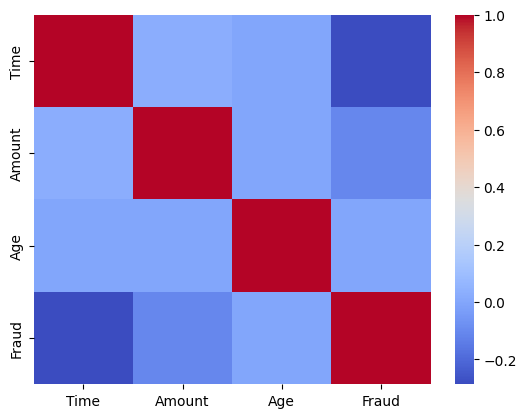

In [ ]:
#CORRELACIÓN ENTRE VARIABLES
sns.heatmap(df.corr(),cmap='coolwarm')
plt.show()

#CODIFICACIÓN

In [ ]:
df_modelo = df.iloc[:,2:]
df_modelo

,Day of Week,Time,Type of Card,Entry Mode,Amount,Type of Transaction,Merchant Group,Country of Transaction,Shipping Address,Country of Residence,Gender,Age,Bank,Fraud
0,Wednesday,19,Visa,Tap,5,POS,Entertainment,United Kingdom,United Kingdom,United Kingdom,M,25.2,RBS,False
1,Wednesday,17,MasterCard,PIN,288,POS,Services,USA,USA,USA,F,49.6,Lloyds,False
2,Wednesday,14,Visa,Tap,5,POS,Restaurant,India,India,India,F,42.2,Barclays,False
3,Tuesday,14,Visa,Tap,28,POS,Entertainment,United Kingdom,India,United Kingdom,F,51.0,Barclays,False
4,Tuesday,23,Visa,CVC,91,Online,Electronics,USA,USA,United Kingdom,M,38.0,Halifax,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,Tuesday,22,MasterCard,Tap,15,POS,Electronics,United Kingdom,United Kingdom,United Kingdom,F,53.8,Halifax,False
99996,Wednesday,23,MasterCard,PIN,7,ATM,Children,Russia,Russia,Russia,M,45.0,Barclays,False
99997,Tuesday,11,MasterCard,PIN,21,ATM,Subscription,United Kingdom,United Kingdom,United Kingdom,F,46.5,HSBC,False
99998,Wednesday,22,Visa,Tap,25,POS,Products,United Kingdom,United Kingdom,United Kingdom,M,48.2,Barclays,False


In [ ]:
df_modelo = pd.get_dummies(df_modelo)
df_modelo['Fraude'] = df_modelo['Fraud']  #REACOMODO DE LA COLUMNA Y
df_modelo = df_modelo.drop('Fraud',axis = 1)
df_modelo = df_modelo.reset_index()
df_modelo

,index,Time,Amount,Age,Day of Week_Tuesday,Day of Week_Wednesday,Type of Card_MasterCard,Type of Card_Visa,Entry Mode_CVC,Entry Mode_PIN,...,Gender_F,Gender_M,Bank_Barclays,Bank_HSBC,Bank_Halifax,Bank_Lloyds,Bank_Metro,Bank_Monzo,Bank_RBS,Fraude
0,0,19,5,25.2,0,1,0,1,0,0,...,0,1,0,0,0,0,0,0,1,False
1,1,17,288,49.6,0,1,1,0,0,1,...,1,0,0,0,0,1,0,0,0,False
2,2,14,5,42.2,0,1,0,1,0,0,...,1,0,1,0,0,0,0,0,0,False
3,3,14,28,51.0,1,0,0,1,0,0,...,1,0,1,0,0,0,0,0,0,False
4,4,23,91,38.0,1,0,0,1,1,0,...,0,1,0,0,1,0,0,0,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99946,99995,22,15,53.8,1,0,1,0,0,0,...,1,0,0,0,1,0,0,0,0,False
99947,99996,23,7,45.0,0,1,1,0,0,1,...,0,1,1,0,0,0,0,0,0,False
99948,99997,11,21,46.5,1,0,1,0,0,1,...,1,0,0,1,0,0,0,0,0,False
99949,99998,22,25,48.2,0,1,0,1,0,0,...,0,1,1,0,0,0,0,0,0,False


#ESTANDARIZACIÓN

In [ ]:
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
#MinMaxScaler rescales the data set such that all feature values are in the range [0, 1]

scaler = MinMaxScaler()

Time_Amount_Age_Scalado = df_modelo[['Time','Amount','Age']]

Time_Amount_Age_Scalado = pd.DataFrame(scaler.fit_transform(Time_Amount_Age_Scalado), columns=Time_Amount_Age_Scalado.columns)
print(Time_Amount_Age_Scalado)

df_modelo = df_modelo.drop(['index','Time','Amount','Age'],axis = 1)

           Time    Amount       Age
0      0.791667  0.000000  0.143460
1      0.708333  0.716456  0.486639
2      0.583333  0.000000  0.382560
3      0.583333  0.058228  0.506329
4      0.958333  0.217722  0.323488
...         ...       ...       ...
99946  0.916667  0.025316  0.545710
99947  0.958333  0.005063  0.421941
99948  0.458333  0.040506  0.443038
99949  0.916667  0.050633  0.466948
99950  0.666667  0.559494  0.234880

[99951 rows x 3 columns]


#X, y SIN BALANCEAR

In [ ]:
X = pd.concat([Time_Amount_Age_Scalado,df_modelo], axis = 1)
X = X.drop('Fraude',axis = 1)

y = df_modelo['Fraude']

print(X.shape)
print(y.shape)

(99951, 47)
(99951,)


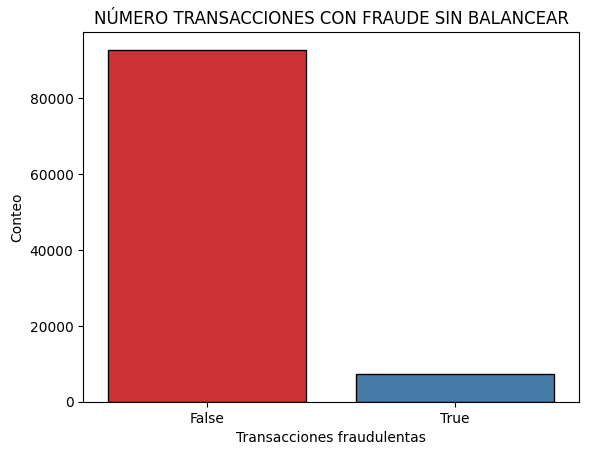

In [ ]:
ax = sns.countplot(x = y, palette = "Set1", edgecolor = "black")
ax.set_title('NÚMERO TRANSACCIONES CON FRAUDE SIN BALANCEAR')
ax.set(xlabel = 'Transacciones fraudulentas')
ax.set(ylabel='Conteo')
plt.show()

In [ ]:
#SEPARACIÓN DE DATOS DE ENTRENAMIENTO Y PRUEBA

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(69965, 47)
(29986, 47)
(69965,)
(29986,)


# X, y con OVERSAMPLER

In [ ]:
#https://imbalanced-learn.org/stable/over_sampling.html
#One way to fight this issue is to generate new samples in the classes which are under-represented. The most naive strategy is to generate new samples by randomly sampling with replacement the current available samples.

In [ ]:
# Crear el objeto RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_oversampler, y_oversampler = ros.fit_resample(X, y)

In [ ]:
y_oversampler

0         False
1         False
2         False
3         False
4          True
          ...  
185519     True
185520     True
185521     True
185522     True
185523     True
Name: Fraude, Length: 185524, dtype: bool

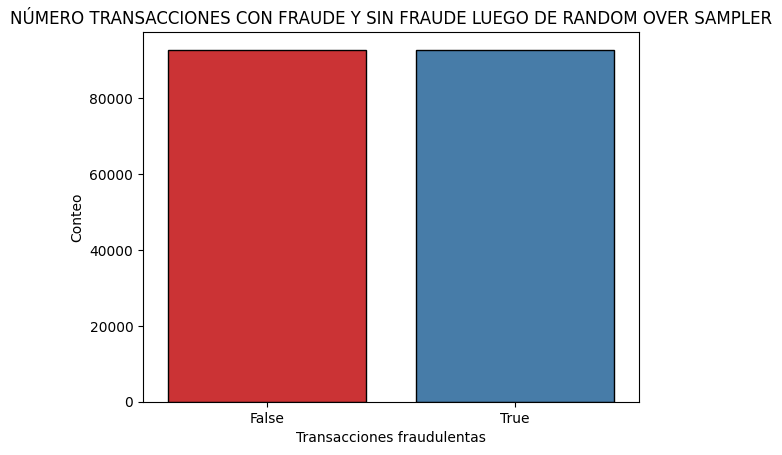

In [ ]:
ax = sns.countplot(x = y_oversampler, palette = "Set1", edgecolor = "black")
ax.set_title('NÚMERO TRANSACCIONES CON FRAUDE Y SIN FRAUDE LUEGO DE RANDOM OVER SAMPLER')
ax.set(xlabel = 'Transacciones fraudulentas')
ax.set(ylabel='Conteo')
plt.show()

In [ ]:
#SEPARACIÓN DE DATOS DE ENTRENAMIENTO Y PRUEBA

X_train_ros, X_test_ros, y_train_ros, y_test_ros = train_test_split(X_oversampler, y_oversampler, test_size=0.3)
print(X_train_ros.shape)
print(X_test_ros.shape)
print(y_train_ros.shape)
print(y_test_ros.shape)

(129866, 47)
(55658, 47)
(129866,)
(55658,)


# X , y con UNDERSAMPLER

In [ ]:
#https://imbalanced-learn.org/stable/under_sampling.html
#Prototype generation technique will reduce the number of samples in the targeted classes but the remaining samples are generated — and not selected — from the original set.

In [ ]:
# Crear el objeto RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

# Aplicar el submuestreo
X_undersampler, y_undersampler = rus.fit_resample(X, y)

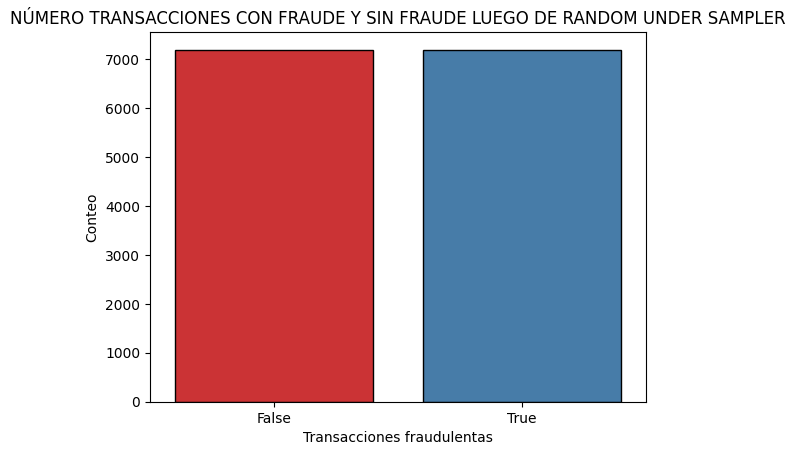

In [ ]:
ax = sns.countplot(x = y_undersampler, palette = "Set1", edgecolor = "black")
ax.set_title('NÚMERO TRANSACCIONES CON FRAUDE Y SIN FRAUDE LUEGO DE RANDOM UNDER SAMPLER')
ax.set(xlabel = 'Transacciones fraudulentas')
ax.set(ylabel='Conteo')
plt.show()

In [ ]:
X_train_rus, X_test_rus, y_train_rus, y_test_rus = train_test_split(X_undersampler, y_undersampler, test_size=0.3)
print(X_train_rus.shape)
print(X_test_rus.shape)
print(y_train_rus.shape)
print(y_test_rus.shape)

(10064, 47)
(4314, 47)
(10064,)
(4314,)


#VALIDACIÓN CRUZADA DE DATOS

In [ ]:
#VALIDACIÓN CRUZADA

kf = KFold(n_splits=100, shuffle=True, random_state=42)


#MODELADO DE LOS DATOS

## REGRESIÓN LOGÍSTICA
**ENRIQUE**

In [ ]:
#REGRESIÓN LOGÍSTICA DATOS SIN BALANCEAR

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
score = logreg.score(X_test, y_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print("Score sin validación cruzada: ", score)

Score sin validación cruzada:  0.9728873474288001


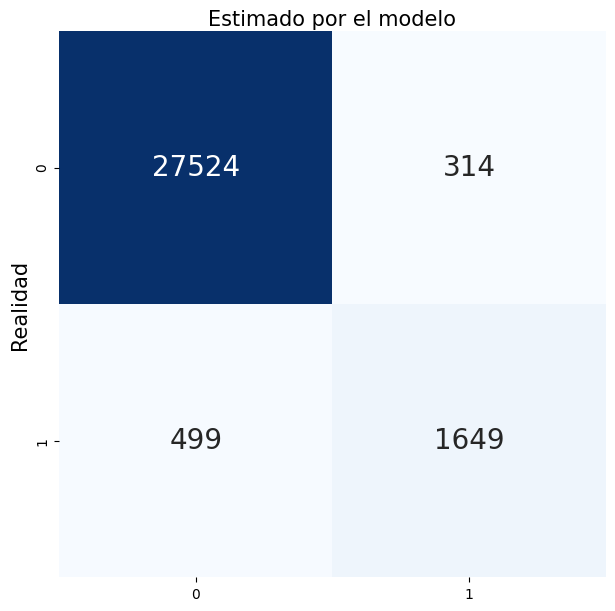

In [ ]:
#MATRIZ DE CONFUSIÓN

class_names=[0,1] # name  of classes
fig, ax = plt.subplots(figsize=(6, 6))
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="Blues" ,fmt='g', cbar=False, annot_kws={"size": 20})
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.ylabel('Realidad', fontsize=15, y=0.5)
plt.xlabel('Estimado por el modelo', fontsize=15);

In [ ]:
#MÉTRICAS Y VALIDACIÓN CRUZADA
#https://scikit-learn.org/stable/modules/cross_validation.html


cross_val_exactitud = cross_val_score(logreg, X_test, y_test, cv=kf)
print("Exactitud por cada fold:", cross_val_exactitud)
print("Exactitud promedio:", np.mean(cross_val_exactitud))
print("----------------------------------")

cross_val_f1 = cross_val_score(logreg, X_test, y_test, cv=kf, scoring='f1')
print("F1 score por cada fold:", cross_val_f1)
print("F1 score promedio:", np.mean(cross_val_f1))
print("----------------------------------")

cross_val_precision = cross_val_score(logreg, X_test, y_test, cv=kf, scoring='precision')
print("Precisión por cada fold:", cross_val_precision)
print("Precisión promedio:", np.mean(cross_val_precision))
print("----------------------------------")

cross_val_recall = cross_val_score(logreg, X_test, y_test, cv=kf, scoring='recall')
print("Sensbilidad  por cada fold:", cross_val_recall)
print("Sensbilidad  promedio:", np.mean(cross_val_recall))
print("----------------------------------")

Exactitud por cada fold: [0.98333333 0.98666667 0.97333333 0.97       0.97666667 0.98
 0.98       0.97333333 0.97666667 0.98       0.97333333 0.97333333
 0.96666667 0.98       0.99333333 0.97333333 0.96333333 0.95333333
 0.96       0.96666667 0.97       0.96       0.96666667 0.97666667
 0.95666667 0.97       0.97       0.97666667 0.96333333 0.97333333
 0.97333333 0.96666667 0.98       0.98333333 0.96       0.97666667
 0.96       0.98666667 0.97666667 0.97333333 0.97666667 0.98
 0.95       0.98       0.96333333 0.95       0.99333333 0.98
 0.97       0.98       0.96333333 0.96       0.97       0.97666667
 0.96       0.98       0.95666667 0.97333333 0.98333333 0.97666667
 0.96333333 0.98333333 0.96666667 0.96666667 0.98       0.97
 0.97333333 0.98       0.97       0.98       0.98       0.97333333
 0.97333333 0.98333333 0.98333333 0.96666667 0.97666667 0.98333333
 0.98       0.97666667 0.96333333 0.98666667 0.97333333 0.97333333
 0.95       0.97333333 0.96989967 0.96655518 0.97658863 0.979

In [ ]:
#REGRESIÓN LOGÍSTICA RANDOM OVER SAMPLER

logreg_ros = LogisticRegression()
logreg_ros.fit(X_train_ros, y_train_ros)
y_pred_ros = logreg_ros.predict(X_test_ros)
score_ros = logreg_ros.score(X_test_ros, y_test_ros)
cnf_matrix_ros = metrics.confusion_matrix(y_test_ros, y_pred_ros)
print("Score sin validación cruzada: ", score_ros)

Score sin validación cruzada:  0.9378346329368644


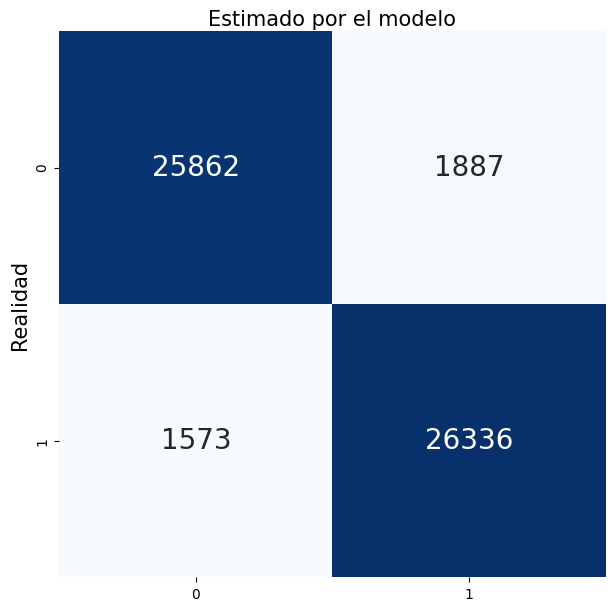

In [ ]:
#MATRIZ DE CONFUSIÓN

class_names=[0,1] # name  of classes
fig, ax = plt.subplots(figsize=(6, 6))
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix_ros), annot=True, cmap="Blues" ,fmt='g', cbar=False, annot_kws={"size": 20})
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.ylabel('Realidad', fontsize=15, y=0.5)
plt.xlabel('Estimado por el modelo', fontsize=15);

In [ ]:
#MÉTRICAS Y VALIDACIÓN CRUZADA ROS

cross_val_exactitud_ros = cross_val_score(logreg_ros, X_test_ros, y_test_ros, cv=kf)
print("Exactitud por cada fold:", cross_val_exactitud_ros)
print("Exactitud promedio:", np.mean(cross_val_exactitud_ros))
print("----------------------------------")

cross_val_f1_ros = cross_val_score(logreg_ros, X_test_ros, y_test_ros, cv=kf, scoring='f1')
print("F1 score por cada fold:", cross_val_f1_ros)
print("F1 score promedio:", np.mean(cross_val_f1_ros))
print("----------------------------------")

cross_val_precision_ros = cross_val_score(logreg_ros, X_test_ros, y_test_ros, cv=kf, scoring='precision')
print("Precisión por cada fold:", cross_val_precision_ros)
print("Precisión promedio:", np.mean(cross_val_precision_ros))
print("----------------------------------")

cross_val_recall_ros = cross_val_score(logreg_ros, X_test_ros, y_test_ros, cv=kf, scoring='recall')
print("Sensbilidad  por cada fold:", cross_val_recall_ros)
print("Sensbilidad  promedio:", np.mean(cross_val_recall_ros))
print("----------------------------------")

Exactitud por cada fold: [0.95152603 0.92280072 0.94075404 0.93895871 0.95332136 0.92100539
 0.95332136 0.9443447  0.95152603 0.92280072 0.93716338 0.93357271
 0.93357271 0.93895871 0.95332136 0.93177738 0.95332136 0.95332136
 0.93716338 0.93177738 0.92818671 0.93895871 0.9443447  0.93895871
 0.94075404 0.94614004 0.93536804 0.9497307  0.93536804 0.91382406
 0.92459605 0.9497307  0.93536804 0.94075404 0.9443447  0.92280072
 0.92639138 0.95332136 0.94075404 0.93536804 0.9497307  0.94075404
 0.93357271 0.92998205 0.94614004 0.94614004 0.9443447  0.93716338
 0.93177738 0.93177738 0.93357271 0.93177738 0.95691203 0.94793537
 0.9551167  0.94793537 0.93357271 0.94075404 0.94604317 0.94244604
 0.9352518  0.93165468 0.92985612 0.9442446  0.92446043 0.9352518
 0.92625899 0.94964029 0.92446043 0.93345324 0.93884892 0.95683453
 0.94604317 0.9352518  0.94964029 0.93705036 0.93345324 0.9352518
 0.93345324 0.93705036 0.93705036 0.93165468 0.92266187 0.94064748
 0.9442446  0.9442446  0.96402878 0.949

In [ ]:
#REGRESIÓN LOGÍSTICA RANDOM UNDER SAMPLER

logreg_rus = LogisticRegression()
logreg_rus.fit(X_train_rus, y_train_rus)
y_pred_rus = logreg_rus.predict(X_test_rus)
score_rus = logreg_rus.score(X_test_rus, y_test_rus)
cnf_matrix_rus = metrics.confusion_matrix(y_test_rus, y_pred_rus)
print("Score sin validación cruzada: ", score_rus)

Score sin validación cruzada:  0.9337042188224386


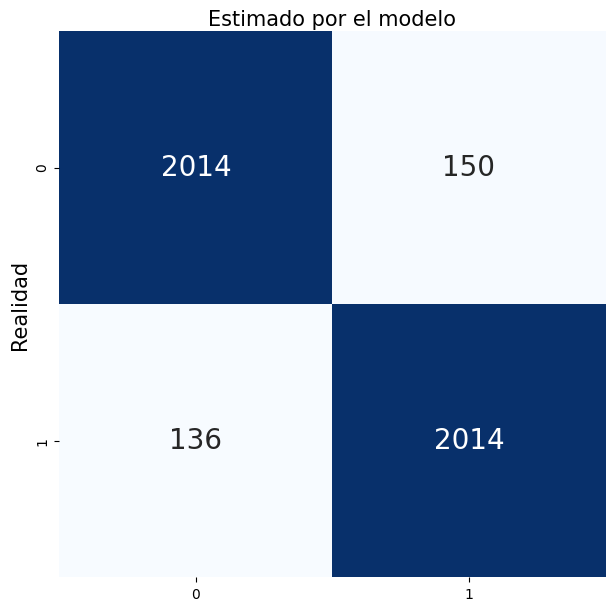

In [ ]:
#MATRIZ DE CONFUSIÓN

class_names=[0,1] # name  of classes
fig, ax = plt.subplots(figsize=(6, 6))
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix_rus), annot=True, cmap="Blues" ,fmt='g', cbar=False, annot_kws={"size": 20})
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.ylabel('Realidad', fontsize=15, y=0.5)
plt.xlabel('Estimado por el modelo', fontsize=15);

In [ ]:
#MÉTRICAS Y VALIDACIÓN CRUZADA RUS

cross_val_exactitud_rus = cross_val_score(logreg_rus, X_test_rus, y_test_rus, cv=kf)
print("Exactitud por cada fold:", cross_val_exactitud_rus)
print("Exactitud promedio:", np.mean(cross_val_exactitud_rus))
print("----------------------------------")

cross_val_f1_rus = cross_val_score(logreg_rus, X_test_rus, y_test_rus, cv=kf, scoring='f1')
print("F1 score por cada fold:", cross_val_f1_rus)
print("F1 score promedio:", np.mean(cross_val_f1_rus))
print("----------------------------------")

cross_val_precision_rus = cross_val_score(logreg_rus, X_test_rus, y_test_rus, cv=kf, scoring='precision')
print("Precisión por cada fold:", cross_val_precision_rus)
print("Precisión promedio:", np.mean(cross_val_precision_rus))
print("----------------------------------")

cross_val_recall_rus = cross_val_score(logreg_rus, X_test_rus, y_test_rus, cv=kf, scoring='recall')
print("Sensbilidad  por cada fold:", cross_val_recall_rus)
print("Sensbilidad  promedio:", np.mean(cross_val_recall_rus))
print("----------------------------------")

Exactitud por cada fold: [0.90909091 0.93181818 0.95454545 0.95454545 0.88636364 0.93181818
 0.86363636 0.86363636 0.88636364 0.97727273 1.         0.97727273
 0.97727273 0.86363636 0.93023256 0.95348837 0.97674419 0.90697674
 0.86046512 0.90697674 0.95348837 1.         0.95348837 0.95348837
 0.88372093 0.93023256 0.95348837 0.90697674 0.93023256 0.95348837
 0.90697674 0.95348837 0.95348837 0.93023256 0.97674419 0.88372093
 0.90697674 0.86046512 0.93023256 0.97674419 0.93023256 1.
 0.95348837 0.90697674 0.95348837 0.93023256 0.97674419 0.90697674
 0.93023256 0.93023256 0.86046512 0.93023256 0.88372093 0.90697674
 0.97674419 0.97674419 0.93023256 0.95348837 0.93023256 0.90697674
 0.88372093 0.8372093  0.97674419 0.93023256 0.90697674 0.86046512
 1.         0.93023256 0.95348837 0.95348837 0.8372093  0.95348837
 0.90697674 0.95348837 0.97674419 0.90697674 0.88372093 0.93023256
 0.95348837 0.86046512 0.95348837 0.88372093 0.93023256 0.95348837
 0.88372093 0.95348837 0.97674419 0.95348837 

### INTERPRETACIÓN DE LOS RESULTADOS REGRESIÓN LOGÍSTICA

Para este modelo se utilizaron las medidas de exactitud o accuracy , F1 Score, precisión y recall o sensibilidad.

**La Exactitud o Accuracy** es el porcentaje de predicciones correctas, tanto si era Fraude y fue clasificado correctamente como si NO era fraude y fue clasificado correctamente.

**F1 Score** fue una variable importante para este proyecto ya que nos resume la precisión y recall/sensibilidad en una sola métrica. Por ello es de gran utilidad cuando la distribución de las clases es desigual caso que tuvimos en nuestro dataset.

**Precisión** es el cociente entre los casos positivos bien clasificados por el modelo y el total de clasificaciones. En forma práctica es  el porcentaje de casos positivos detectados. Era fraude y se clasifico correctamente.

**Recall o Sensibilidad** es la proporción entre los casos positivos bien clasificados por el modelo, respecto al total de positivos reales.

Cabe resaltar que se crearon 3 diferentes modelos del mismo tipo (Regresión Logística y Decision Tree)

Se crearon 3 diferentes modelos ya que cada uno de ellos se basó en diferentes datos de entrenamiento, prueba y predicción. El primer modelo fue entrenado con datos sin balancear, el segundo modelo utilizó datos con RandomOverSampler y el tercer modelo utilizó datos con RandomUnderSampler.

En el primer modelo pudimos observar que hay una buena exactitud de la clasificación, sin embargo era poco sensible, es decir se le escapaban muchos casos de fraude.

La precisión y la sensibilidad eran considerablemente bajas, por lo que la F1 Score también lo era. Debido a este detalle fue como se aplicó la técnica de balanceo de datos.

Posterior a este balanceo de datos las métricas en general presentaron un buen desempeño. Llegando a estar en alrededor de 93%. Sin embargo no tan bueno como el siguiente modelo a analizar.


## ÁRBOL DE DECISIÓN
**DANIEL**


In [ ]:
# Creación del modelo con parámetros estándar
mod_tree_class = DecisionTreeClassifier(random_state=42)

# Entrenar el modelo y realizar evaluación en el conjunto de datos original sin balancear
mod_tree_class.fit(X_train, y_train)
y_pred = mod_tree_class.predict(X_test)

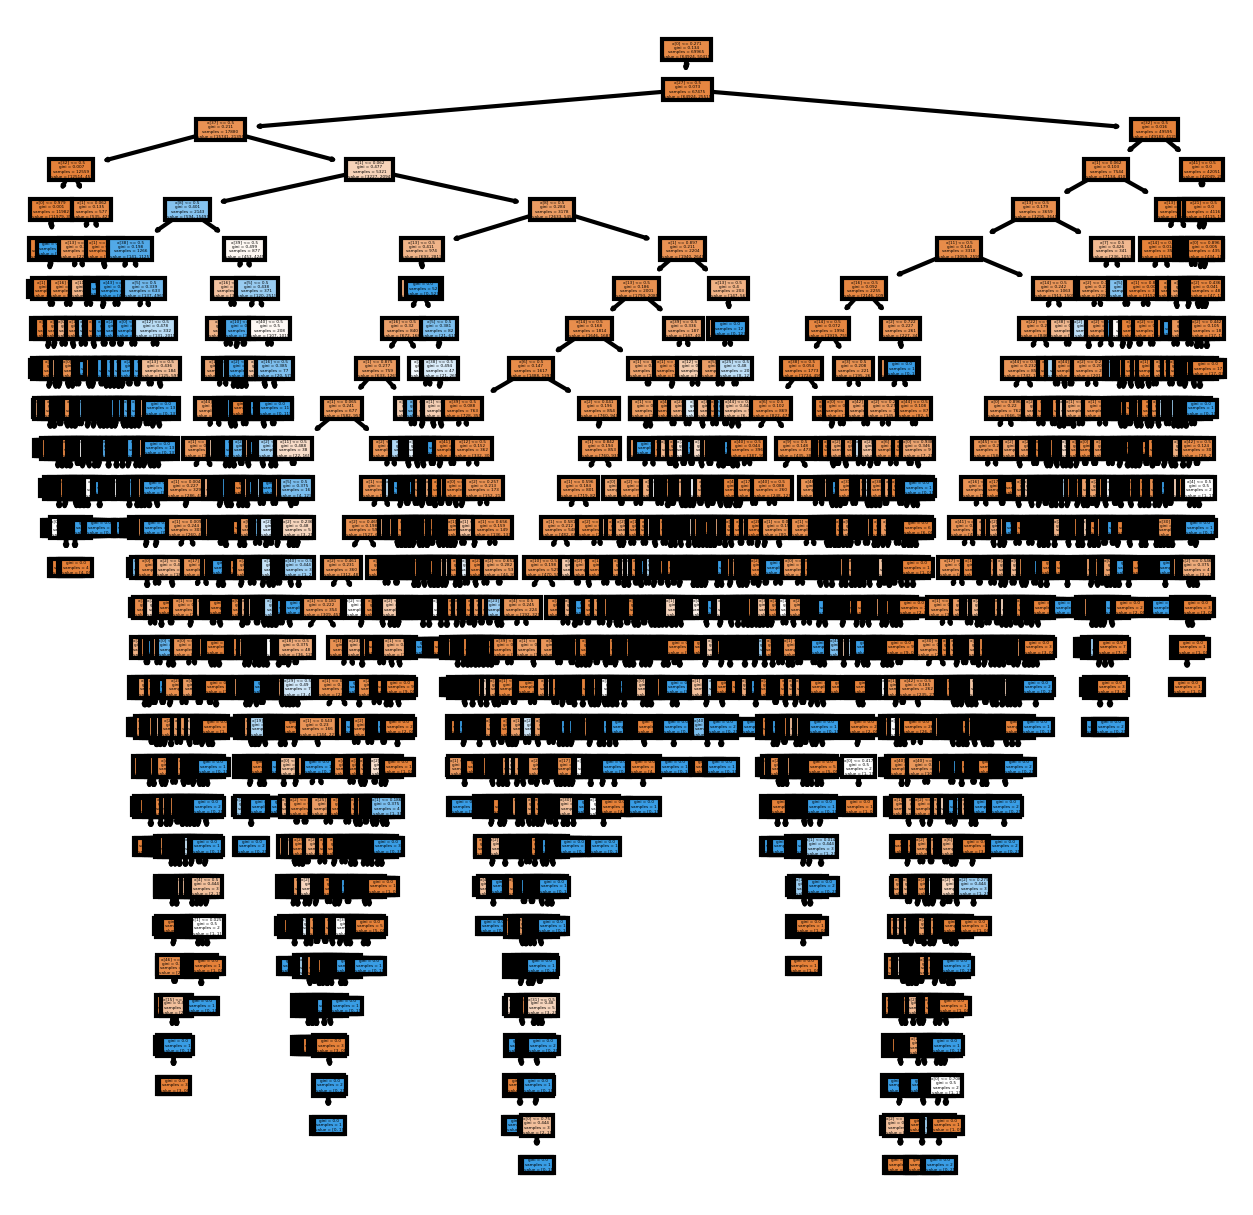

In [ ]:
plt.figure(figsize = (5,5), dpi = 300)
treeClassifier.plot_tree(mod_tree_class,filled = True);
plt.show()

In [ ]:
# Creación del modelo con parámetros estándar
mod_tree_class_ros = DecisionTreeClassifier(random_state=42)

# Entrenar el modelo con el conjunto de datos oversampled (ROS)
mod_tree_class_ros.fit(X_train_ros, y_train_ros)
y_pred_ros = mod_tree_class.predict(X_test_ros)

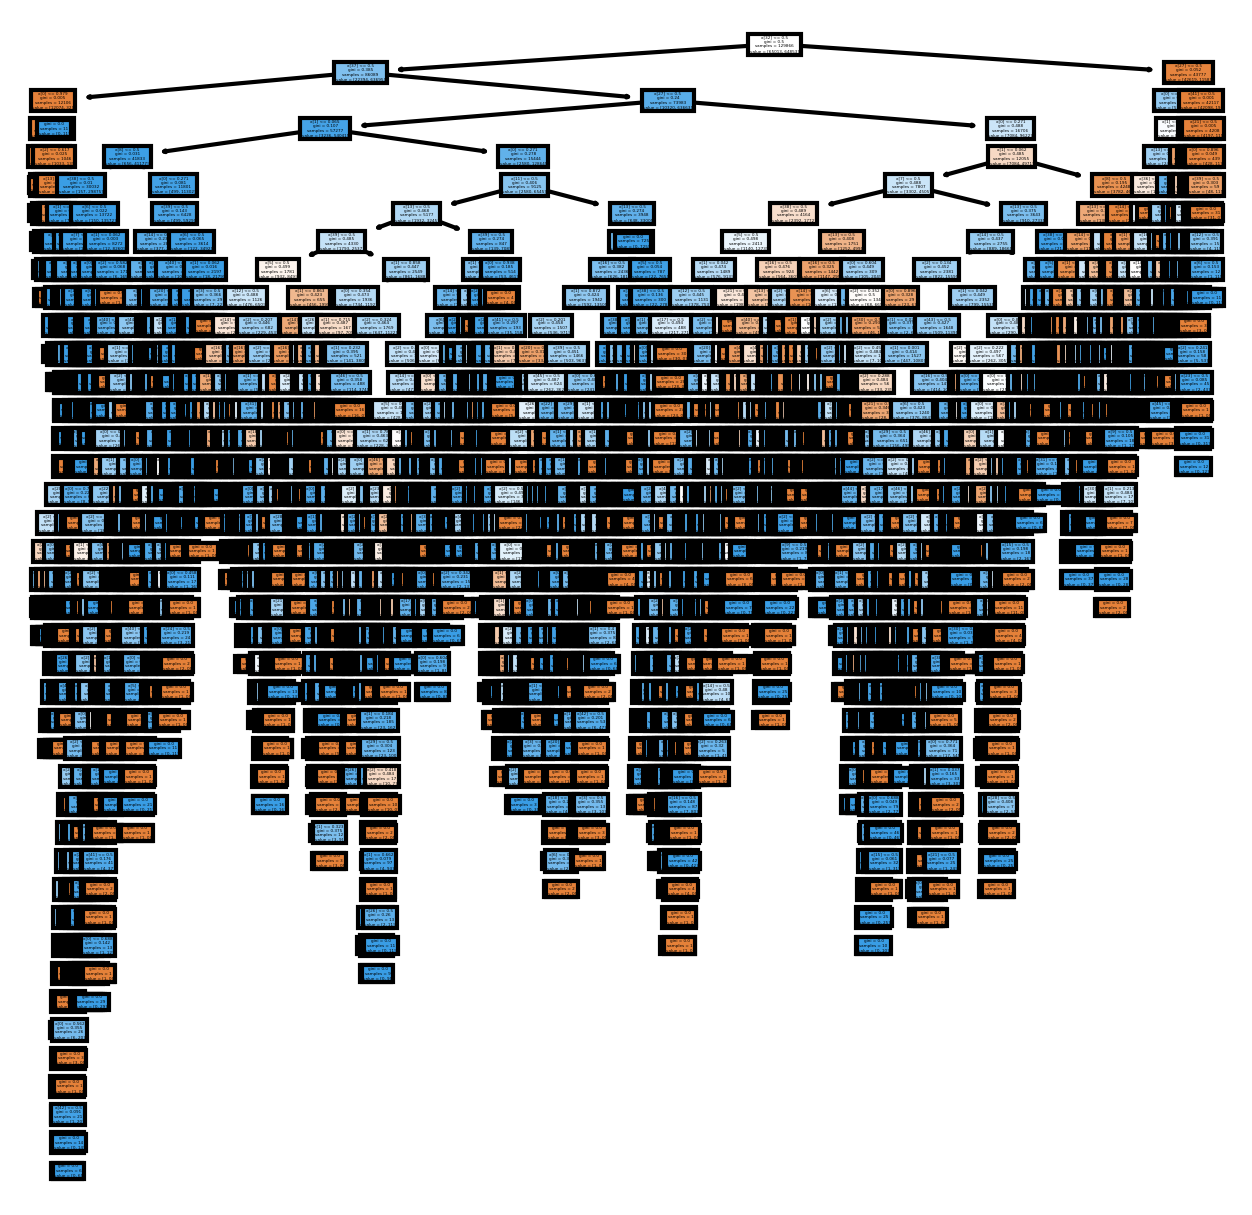

In [ ]:
plt.figure(figsize = (5,5), dpi = 300)
treeClassifier.plot_tree(mod_tree_class_ros,filled = True);
plt.show()

In [ ]:
# Creación del modelo con parámetros estándar
mod_tree_class_rus = DecisionTreeClassifier(random_state=42)

# Entrenar el modelo con el conjunto de datos undersampled (RUS)
mod_tree_class_rus.fit(X_train_rus, y_train_rus)
y_pred_rus = mod_tree_class.predict(X_test_rus)

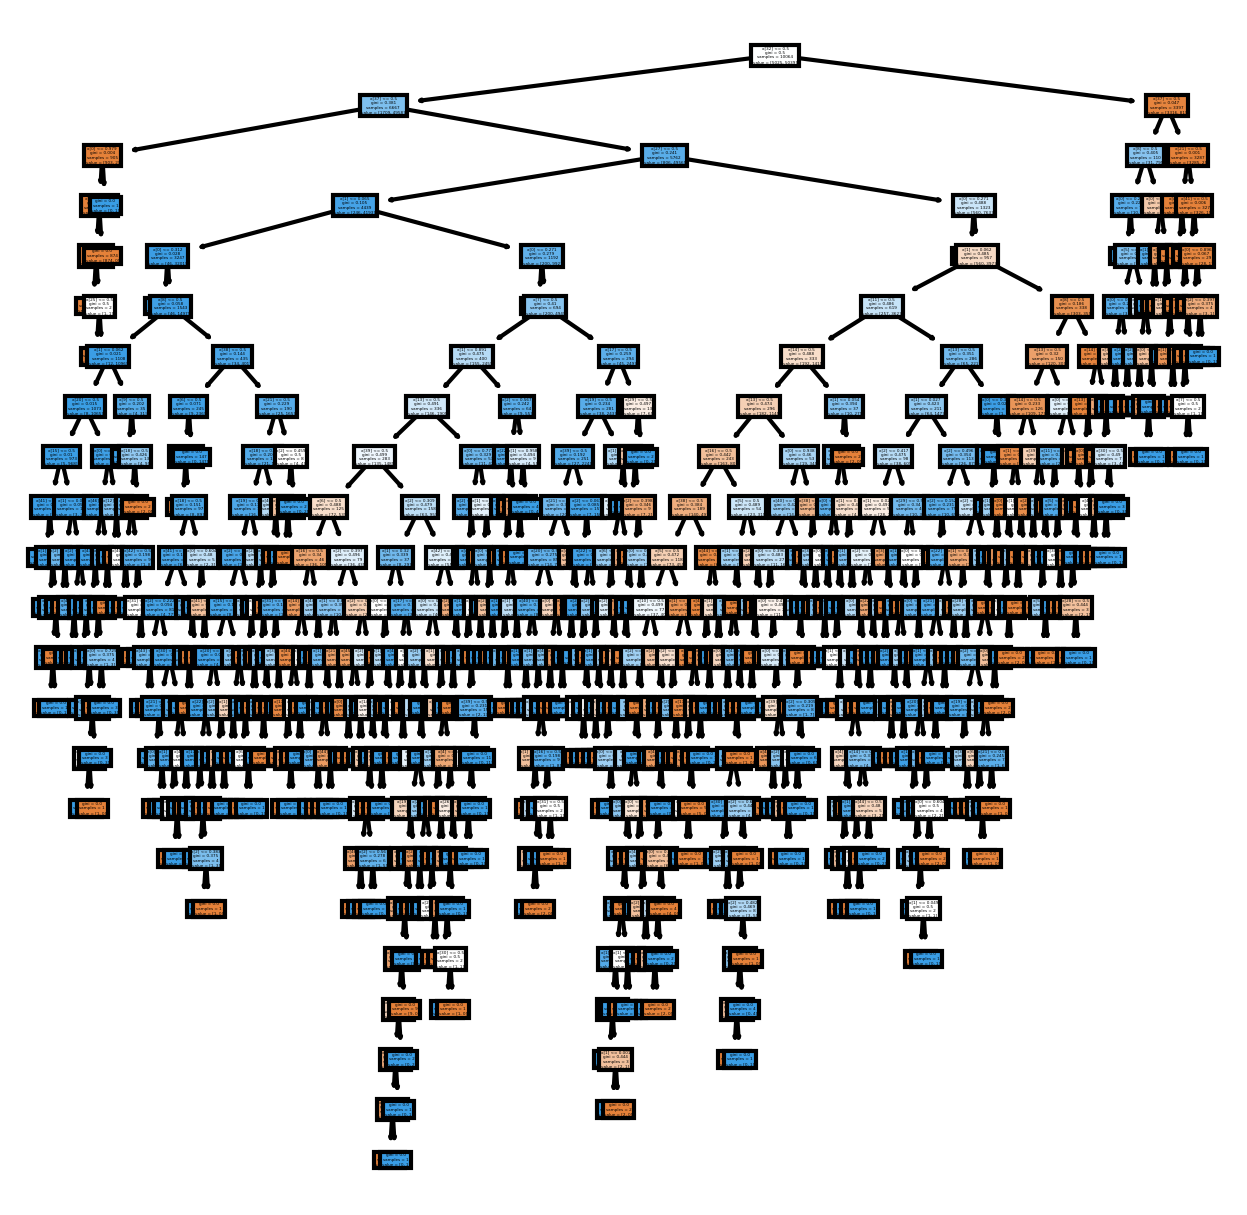

In [ ]:
plt.figure(figsize = (5,5), dpi = 300)
treeClassifier.plot_tree(mod_tree_class_rus,filled = True);
plt.show()

### MÉTRICAS DE ÁRBOL DE DECISIÓN

Exactitud por cada fold: [0.97666667 0.98       0.98       0.97666667 0.99       0.97333333
 0.97666667 0.99333333 0.98       0.98333333 0.97       0.98666667
 0.97333333 0.98333333 0.98333333 0.96333333 0.97666667 0.97333333
 0.98       0.95333333 0.97       0.98666667 0.97       0.97333333
 0.97333333 0.98       0.99       0.97       0.97       0.97333333
 0.97       0.97666667 0.97666667 0.98666667 0.97666667 0.97666667
 0.97333333 0.99       0.98       0.97333333 0.98       0.98333333
 0.95666667 0.99       0.96666667 0.97333333 0.98666667 0.98333333
 0.97666667 0.98666667 0.98       0.96333333 0.99333333 0.97666667
 0.97       0.97333333 0.96666667 0.98666667 0.98333333 0.97666667
 0.97       0.98       0.97666667 0.96       0.98333333 0.98
 0.98       0.98333333 0.96666667 0.97       0.99       0.97666667
 0.98       0.98333333 0.98       0.98333333 0.96666667 0.98
 0.98       0.98666667 0.98       0.99       0.95666667 0.97
 0.96666667 0.99       0.98327759 0.97658863 0.98996656

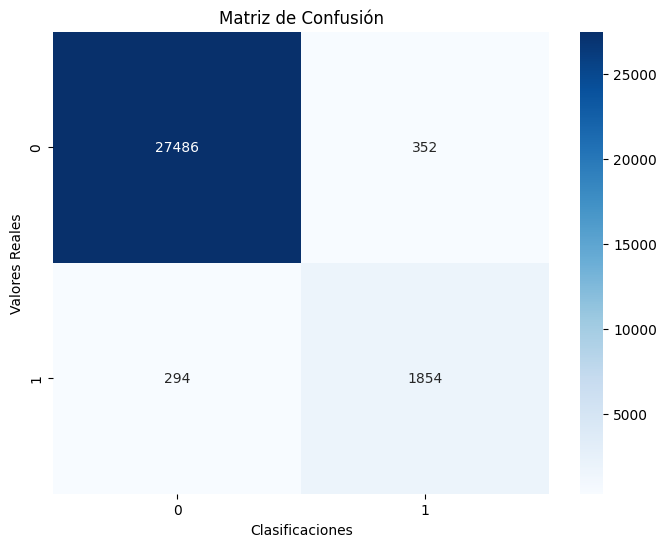

In [ ]:
# sin balancear

cross_val_exactitud = cross_val_score(mod_tree_class, X_test, y_test, cv=kf)
print("Exactitud por cada fold:", cross_val_exactitud)
print("Exactitud promedio:", np.mean(cross_val_exactitud))
print("----------------------------------")

cross_val_f1 = cross_val_score(mod_tree_class, X_test, y_test, cv=kf, scoring='f1')
print("F1 score por cada fold:", cross_val_f1)
print("F1 score promedio:", np.mean(cross_val_f1))
print("----------------------------------")

cross_val_precision = cross_val_score(mod_tree_class, X_test, y_test, cv=kf, scoring='precision')
print("Precisión por cada fold:", cross_val_precision)
print("Precisión promedio:", np.mean(cross_val_precision))
print("----------------------------------")

cross_val_recall = cross_val_score(mod_tree_class, X_test, y_test, cv=kf, scoring='recall')
print("Sensbilidad  por cada fold:", cross_val_recall)
print("Sensbilidad  promedio:", np.mean(cross_val_recall))
print("----------------------------------")


# Calcular la matriz de confusión. Crear una figura. Utilizar seaborn para crear una representación visual
confusion = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues")

plt.xlabel('Clasificaciones')
plt.ylabel('Valores Reales')
plt.title('Matriz de Confusión')
plt.show()

Exactitud por cada fold: [0.98743268 0.98563734 0.98922801 0.98922801 0.99102334 0.98743268
 0.98384201 0.99102334 0.98384201 0.98384201 0.98025135 0.99102334
 0.97486535 0.98025135 0.99102334 0.98025135 0.98743268 0.98922801
 0.98922801 0.97845601 0.97307002 0.98743268 0.98743268 0.98922801
 0.97486535 0.98204668 0.98743268 0.98025135 0.98204668 0.98384201
 0.98922801 0.98384201 0.98743268 0.97666068 0.99102334 0.98743268
 0.97127469 0.98922801 0.99102334 0.98922801 0.98922801 0.98384201
 0.98384201 0.98743268 0.98384201 0.98922801 0.98204668 0.98204668
 0.98563734 0.98922801 0.98204668 0.99281867 0.99640934 0.98743268
 0.99102334 0.98743268 0.98025135 0.98025135 0.98741007 0.98741007
 0.97841727 0.97841727 0.98920863 0.97482014 0.98561151 0.98561151
 0.98021583 0.99100719 0.98561151 0.98561151 0.99280576 0.98741007
 0.98741007 0.98741007 0.98741007 0.98741007 0.98021583 0.98741007
 0.98201439 0.98561151 0.98201439 0.98021583 0.98381295 0.98381295
 0.98561151 0.97661871 0.99280576 0.9

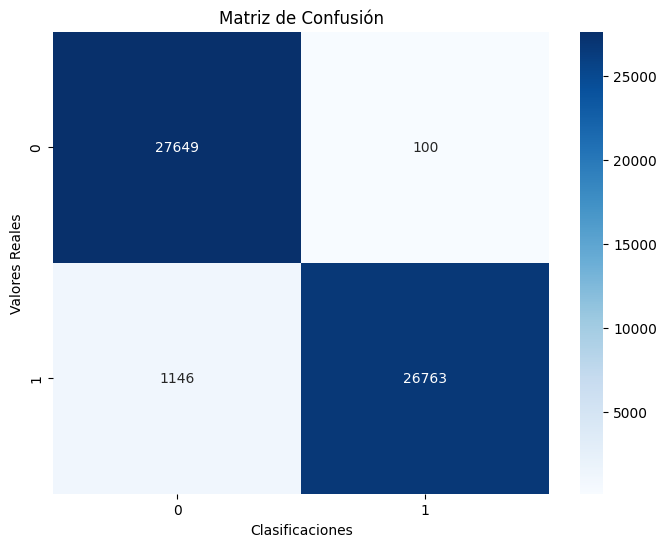

In [ ]:
# oversampler

cross_val_exactitud_ros = cross_val_score(mod_tree_class_ros, X_test_ros, y_test_ros, cv=kf)
print("Exactitud por cada fold:", cross_val_exactitud_ros)
print("Exactitud promedio:", np.mean(cross_val_exactitud_ros))
print("----------------------------------")

cross_val_f1_ros = cross_val_score(mod_tree_class_ros, X_test_ros, y_test_ros, cv=kf, scoring='f1')
print("F1 score por cada fold:", cross_val_f1_ros)
print("F1 score promedio:", np.mean(cross_val_f1_ros))
print("----------------------------------")

cross_val_precision_ros = cross_val_score(mod_tree_class_ros, X_test_ros, y_test_ros, cv=kf, scoring='precision')
print("Precisión por cada fold:", cross_val_precision_ros)
print("Precisión promedio:", np.mean(cross_val_precision_ros))
print("----------------------------------")

cross_val_recall_ros = cross_val_score(mod_tree_class_ros, X_test_ros, y_test_ros, cv=kf, scoring='recall')
print("Sensbilidad  por cada fold:", cross_val_recall_ros)
print("Sensbilidad  promedio:", np.mean(cross_val_recall_ros))
print("----------------------------------")




confusion = confusion_matrix(y_test_ros, y_pred_ros)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues")

plt.xlabel('Clasificaciones')
plt.ylabel('Valores Reales')
plt.title('Matriz de Confusión')
plt.show()

Exactitud por cada fold: [0.90909091 0.93181818 0.88636364 0.93181818 0.93181818 0.93181818
 0.95454545 0.95454545 0.95454545 0.97727273 0.93181818 1.
 0.97727273 0.90909091 0.95348837 0.97674419 0.97674419 0.90697674
 0.97674419 0.88372093 0.97674419 0.97674419 0.95348837 1.
 0.95348837 0.95348837 0.97674419 0.95348837 1.         0.95348837
 0.88372093 0.90697674 0.88372093 0.88372093 0.97674419 0.97674419
 0.93023256 0.86046512 0.93023256 1.         0.97674419 1.
 0.93023256 0.97674419 0.95348837 0.88372093 0.95348837 0.90697674
 0.97674419 0.95348837 0.90697674 0.90697674 0.95348837 0.93023256
 0.97674419 1.         0.97674419 0.93023256 0.93023256 0.95348837
 0.88372093 0.8372093  0.90697674 0.90697674 0.93023256 0.97674419
 1.         0.88372093 0.97674419 0.95348837 0.88372093 0.93023256
 0.90697674 0.90697674 0.95348837 0.95348837 0.88372093 0.86046512
 0.97674419 0.97674419 0.93023256 0.86046512 0.93023256 0.95348837
 0.8372093  0.90697674 0.95348837 0.88372093 0.90697674 0.953

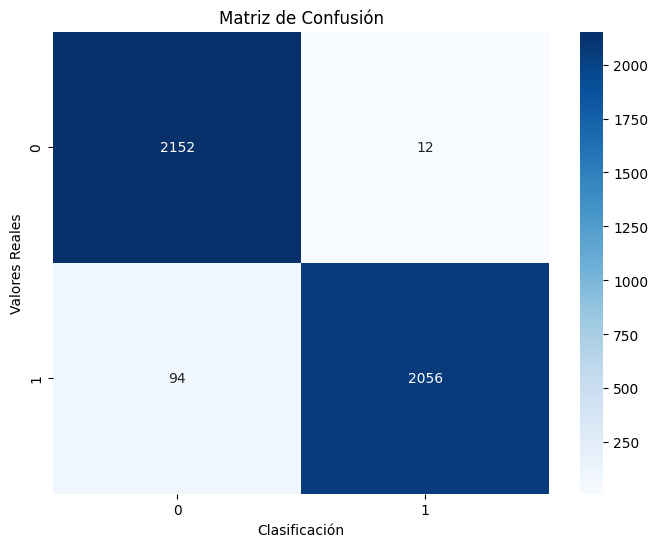

In [ ]:
# undersampler

cross_val_exactitud_rus = cross_val_score(mod_tree_class_rus, X_test_rus, y_test_rus, cv=kf)
print("Exactitud por cada fold:", cross_val_exactitud_rus)
print("Exactitud promedio:", np.mean(cross_val_exactitud_rus))
print("----------------------------------")

cross_val_f1_rus = cross_val_score(mod_tree_class_rus, X_test_rus, y_test_rus, cv=kf, scoring='f1')
print("F1 score por cada fold:", cross_val_f1_rus)
print("F1 score promedio:", np.mean(cross_val_f1_rus))
print("----------------------------------")

cross_val_precision_rus = cross_val_score(mod_tree_class_rus, X_test_rus, y_test_rus, cv=kf, scoring='precision')
print("Precisión por cada fold:", cross_val_precision_rus)
print("Precisión promedio:", np.mean(cross_val_precision_rus))
print("----------------------------------")

cross_val_recall_rus = cross_val_score(mod_tree_class_rus, X_test_rus, y_test_rus, cv=kf, scoring='recall')
print("Sensbilidad  por cada fold:", cross_val_recall_rus)
print("Sensbilidad  promedio:", np.mean(cross_val_recall_rus))
print("----------------------------------")

confusion = confusion_matrix(y_test_rus, y_pred_rus)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues")

plt.xlabel('Clasificación')
plt.ylabel('Valores Reales')
plt.title('Matriz de Confusión')
plt.show()

### INTERPRETACIÓN DE LOS RESULTADOS ÁRBOL DE DECISIÓN

**Árbol de decisión sin balancear:** la exactitud de éste modelo fue buena, sin embargo el resto de métricas, fue inferior a los encontrados con
los modelos de regresión logística. Esto se debe a la tendencia del modelo a los falsos negativos, debido a la proporción baja entre fraudes y no fraudes.

**Árbol de decisión oversampler:** Tiene la exactitud más alta (alta tasa de clasificaciones correctas, sin importar el tipo de clasificación). Precisión y sensibilidad también tienen los valores más altos de entre todos los modelos evaluados, es el mejor modelo clasificando positivos.

Es muy probables que si el modelo arroja un positivo, sea correcto. Y es probable también que haya un número muy bajo de falsos negativos, esto es especialmente importante en éste tipo de casos donde capturar todos los positivos es crucial.
Por lo que su desempeño para clasificar fraudes en nuestro dataset es superior al resto de modelos.

**Árbol de decisión undersampler:** Éste modelo obtiene resultados muy semejantes a los obtenidos en la regresión logísitica con over y undersampler, las 4 métricas se mantienen balanceadas y arriba del 93%